# Face Parsing
based on CelebAMask-HQ dataset https://github.com/switchablenorms/CelebAMask-HQ/tree/master

In [ ]:
# !git clone https://github.com/zllrunning/face-parsing.PyTorch.git face-parsing
# !cp -r face-parsing/* ./

fatal: destination path 'face-parsing' already exists and is not an empty directory.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# img_path = "/content/drive/MyDrive/Data/WIN_20240125_07_57_42_Pro.jpg"
# model_path = "/content/drive/MyDrive/Data/FaceParsing/79999_iter.pth"
# model_path_loc = "face-parsing/res/cp/79999_iter.pth"


In [ ]:
# !mkdir -p res/cp && cp {model_path} res/cp/

In [ ]:
# !mkdir -p res/img && cp {img_path} res/img/
# !mkdir -p res/out

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image



In [9]:
img_path = "res/img/WIN_20240125_07_57_42_Pro.jpg"
model_path = "res/cp/79999_iter.pth"


In [3]:
import evaluate

In [4]:
evaluate.evaluate("res/out","res/img", cp="79999_iter.pth")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/rohr/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%
/home/rohr/Software/Repos/face-parsing/evaluate.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open a

In [5]:
img_in = plt.imread("res/img/WIN_20240125_07_57_42_Pro.jpg")
img_out = plt.imread("res/out/WIN_20240125_07_57_42_Pro.jpg")
img_out_corrected = cv2.resize(img_out, (img_in.shape[1], img_in.shape[0]))

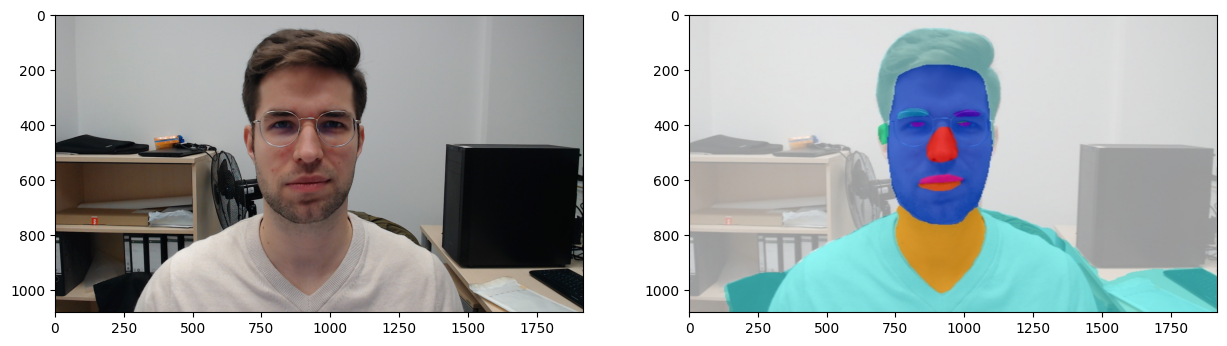

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_in)
plt.subplot(1,2,2)
plt.imshow(img_out_corrected)

In [7]:
from model import BiSeNet
import torch
import os.path as osp
import torchvision.transforms as transforms

model_name = "79999_iter.pth"
n_classes = 19
net = BiSeNet(n_classes=n_classes)
net.cuda()
save_pth = osp.join('res/cp', model_name)
net.load_state_dict(torch.load(save_pth))

def create_mask(image):
  net.eval()
  to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
  img = to_tensor(image)
  img = torch.unsqueeze(img, 0)
  img = img.cuda()
  out = net(img)[0]
  parsing = out.squeeze(0).detach().cpu().numpy().argmax(0)
  return parsing

/tmp/ipykernel_872909/1039222919.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(save_pth))


In [23]:
input_img =Image.open(img_path)
input_img.size

(1920, 1080)

In [10]:
input_img =Image.open(img_path)
input_img = input_img.resize((512, 512), Image.BILINEAR)
mask = create_mask(input_img)

In [11]:
img_in = plt.imread("res/img/WIN_20240125_07_57_42_Pro.jpg")
mask_corrected = cv2.resize(mask.astype(np.uint8), (img_in.shape[1], img_in.shape[0]))

In [12]:
skin_label = 1
background_label = 0
cloth_label = 16
hair_label = 17

In [20]:
skin_mask = mask_corrected==skin_label
flame_mask = ~((mask_corrected==hair_label) | (mask_corrected==background_label))
flame_mask2 = ~((mask_corrected==hair_label) | (mask_corrected==background_label) | (mask_corrected==cloth_label))
img_in_masked = img_in.copy()
img_in_masked[~skin_mask] = 0
kernel = np.ones((5,5),np.uint8)
flame_mask2_filt = cv2.morphologyEx(flame_mask2.astype(np.uint8)*255,cv2.MORPH_OPEN,kernel)>128
img_in_masked_flame = img_in.copy()
img_in_masked_flame[~flame_mask2_filt] = 0


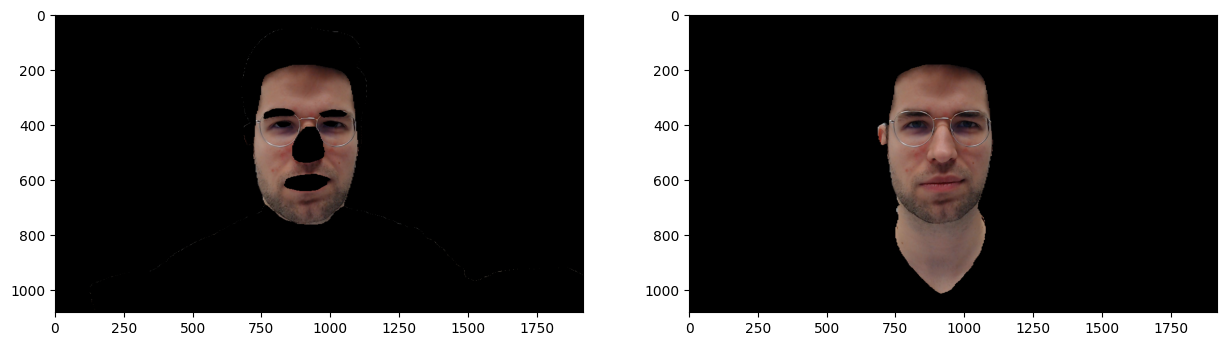

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_in_masked)
plt.subplot(1,2,2)
plt.imshow(img_in_masked_flame)